<a href="https://colab.research.google.com/github/baalasangar/MLAI/blob/master/13_Capstone/Model_building_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective:
 - Train  a neural network model which can predict is the patience is affected or not.
 - sample images are taken from the population ( considering the distripution of the data like *****)
 - sample  Train Image - 500 postive images 500 negative images
 - sample Test Image - 50 postive and 50 negative images
 - xray images of 512 * 512 are the input to the model
 - evaluation metrics - recall
 - conclution is performed with comparing different models ( classification metrix, loss vs accuracy & classification report ) 






### Load lib and data

In [90]:
!pip install pydicom

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split


import cv2
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import pickle

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s :: %(levelname)s :: %(message)s')



import tensorflow as tf

In [93]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [94]:
META_DATA = "/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/final_data.csv"
DATA_ROOT_PATH = "/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/"


META_DATA,DATA_ROOT_PATH

('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/final_data.csv',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/')

In [95]:
metadata_df = pd.read_csv(META_DATA)
metadata_df.drop(labels= ["Unnamed: 0"], axis=1,inplace=True)
metadata_df.head()

,patientId,x,y,width,height,Target,class,filepath,Train_or_Test,area,age,sex,ViewPosition,BodyPartExamined
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,51,F,PA,CHEST
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,48,F,PA,CHEST
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,19,M,AP,CHEST
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,28,M,PA,CHEST
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,80727.0,32,F,AP,CHEST


### sample data for model building
 - from EDA , ViewPosition  ( PA and AP  ) influence the orientation of the xray . So the sampling is done by considering  ViewPosition

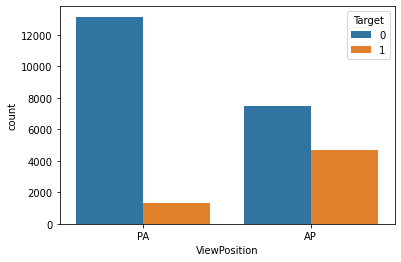

In [96]:
sns.countplot(data = metadata_df[["patientId","Target","ViewPosition"]].drop_duplicates(),x="ViewPosition",hue="Target")
plt.show()

In [97]:
SAMPLE_SIZE = 650
sampled_metadata = pd.DataFrame(columns=["patientId","Target","ViewPosition","filepath"])

In [98]:
pa_count = metadata_df.query("ViewPosition == 'PA' & Target == 1")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]
ap_count = metadata_df.query("ViewPosition == 'AP' & Target == 1")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]

pa_count_sample_size = int(round(pa_count / (pa_count+ap_count),2) * SAMPLE_SIZE)
ap_count_sample_size = int(round(ap_count / (pa_count+ap_count),2) * SAMPLE_SIZE)

print(pa_count_sample_size,ap_count_sample_size)

sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'PA' & Target == 1")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=pa_count_sample_size,random_state=RANDOM_SEED))
sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'AP' & Target == 1")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=ap_count_sample_size,random_state=RANDOM_SEED))


143 507


In [99]:
pa_count = metadata_df.query("ViewPosition == 'PA' & Target == 0")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]
ap_count = metadata_df.query("ViewPosition == 'AP' & Target == 0")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]

pa_count_sample_size = int(round(pa_count / (pa_count+ap_count),2) * SAMPLE_SIZE)
ap_count_sample_size = int(round(ap_count / (pa_count+ap_count),2) * SAMPLE_SIZE)

print(pa_count_sample_size,ap_count_sample_size)

sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'PA' & Target == 0")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=pa_count_sample_size,random_state=RANDOM_SEED))
sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'AP' & Target == 0")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=ap_count_sample_size,random_state=RANDOM_SEED))


416 234


In [100]:
sampled_metadata.reset_index(drop=True,inplace=True )
print(sampled_metadata.shape)
sampled_metadata.head()

(1300, 4)


,patientId,Target,ViewPosition,filepath
0,e18c7203-a029-4cf4-8151-2bc2460c390c,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
1,18ce990f-bea9-4174-a6a2-8f61c4517b24,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
2,068b608d-f71c-4859-b909-62c1665b507f,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
3,9fa17c26-8aae-4dd6-af8a-5750f042adf9,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
4,722503cf-a801-415b-a10e-848bfea55911,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...


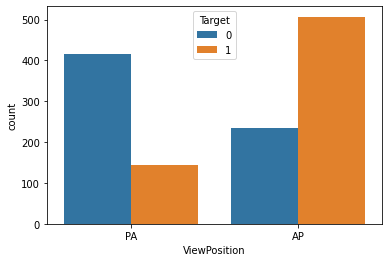

In [101]:
# distibution of the sample dataset similar to the population 

sns.countplot(data = sampled_metadata,x="ViewPosition",hue="Target")

### reading , postprocessing, reshaping Img

In [102]:
### reading the image and storing it as pickle for later access

# def read_img(index_list):
#   image_list = []
#   label_list = []
#   for index in index_list:
#     filePath = sampled_metadata.loc[index]["filepath"]
#     image_list.append(dicom.dcmread(filePath).pixel_array)
#     label_list.append(sampled_metadata.loc[index]["Target"])
#   return image_list,label_list

# index_list = list(sampled_metadata.index)
# X,y = read_img(index_list)
# X = np.array(X)
# y = np.array(y)

# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/image_list.pkl','wb') as f:
#   pickle.dump(X, f)

# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/label_list.pkl','wb') as f:
#   pickle.dump(y, f)  

#### reading img

In [106]:
with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/image_list.pkl','rb') as f:
  X_image_list = pickle.load(f)

with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/label_list.pkl','rb') as f:
  y_lable_value = pickle.load(f)

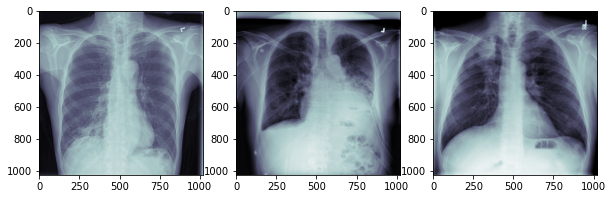

In [110]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_list[i],"bone") 
plt.show()

#### CLAHE processing - improve the contrast of images
 - Contrast Limited Adaptive Histogram Equalization (CLAHE) to equalize images. CLAHE is a variant of Adaptive histogram equalization (AHE) which takes care of over-amplification of the contrast
 

In [111]:
def CLAHEprocessing(img):
  clahe = cv2.createCLAHE(clipLimit = 5)
  clahe_img = clahe.apply(img) + 30
  return clahe_img

X_image_list = [CLAHEprocessing(img) for img in X_image_list]

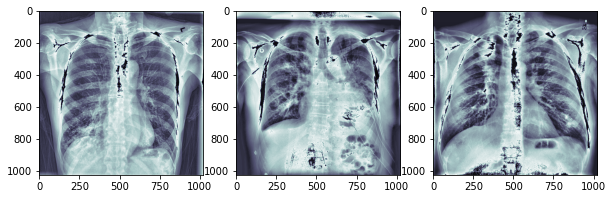

In [112]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_list[i],"bone") 
plt.show()

#### reshaping image

In [113]:
IMG_HEIGHT_WIDTH = 512
# resizing the image 512 * 512
X_image_reshaped = [cv2.resize(img,(IMG_HEIGHT_WIDTH,IMG_HEIGHT_WIDTH)) for img in X_image_list]
print("Shape of the image after resizing", X_image_reshaped[0].shape)

Shape of the image after resizing (512, 512)


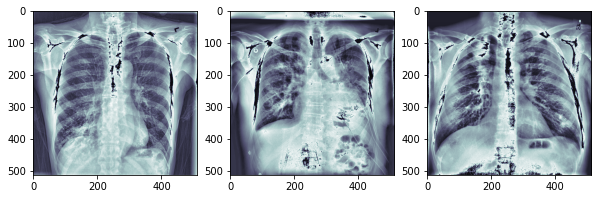

In [115]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_reshaped[i],"bone") 
plt.show()

In [116]:
# index = list(sampled_metadata.query("patientId == 'e18c7203-a029-4cf4-8151-2bc2460c390c'").index)
# testpath = sampled_metadata.loc[index[0]]["filepath"]
# img = dicom.dcmread(testpath).pixel_array
# # logging.info(testpath, testpath.dtype)
# # img = dicom.dcmread(testpath).pixel_array
# print(img.shape,img.min(),img.max())
# plt.imshow(img,"bone") 
# plt.show()

# img = cv2.resize(img,(512,512),interpolation = cv2.INTER_AREA)
# plt.imshow(img,"bone") 
# plt.show()
# print(img.shape,img.min(),img.max())


# clahe = cv2.createCLAHE(clipLimit = 5)
# clahe_img = clahe.apply(img) + 30
# plt.imshow(clahe_img,"bone") 
# plt.show()


### Train & test data split

In [121]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_image_reshaped), y_lable_value, test_size=0.2, random_state=RANDOM_SEED,stratify=y_lable_value)

In [122]:
print("X_train data shape ", X_train.shape)
print("y_train data shape ", y_train.shape)

print("X_test data shape ", X_test.shape)
print("y_test data shape ", y_test.shape)


X_train data shape  (1040, 512, 512)
y_train data shape  (1040,)
X_test data shape  (260, 512, 512)
y_test data shape  (260,)


In [130]:
print("distribution in Train \n", np.array(np.unique(y_train, return_counts=True)).T)
print("distribution in Test \n", np.array(np.unique(y_test, return_counts=True)).T)

distribution in Train 
 [[  0 520]
 [  1 520]]
distribution in Test 
 [[  0 130]
 [  1 130]]


In [ ]:
X_train[0:2]

### Model Building
 - Inscepton Model ( transfer learning ) 
 - Resnet ( transfer learning ) 
 - Model from scratch
 